# Remove Shadows Using Optimal Transport

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mrahnis/nb-vegetation/blob/main/Veggie-Forest.ipynb)

- Load the shade mask and the sun mask from Step 3
- Sample the shade pixels
- Sample the nearest sun pixel with 8 sun pixel neighbors +/- in the direction of the shadow
- Make the OT model
    + transform and inverse_transform?
    + https://pythonot.github.io/auto_examples/domain-adaptation/plot_otda_color_images.html
- Train the OT model with the samples
    + Include distance or spatial location as a dimension?
    + distance matrix of all shade to all sun
    + should L*, a*, b*, other dimensions be normalized or weighted? As-is L* ranges 0-100; a* and b* range -128 to +127
    + or is HSV better (probably YES)
    + above is thinking about relative distance represented by each different dimension...
- Fit the full dataset
- Saves the shadow-corrected image

- What if I just throw NIR/255 in with HSV and see what OT does...?
- You can also supply labels to the OT fit and transform and they'll travel along

In [20]:
# if the notebook is running in colab we'll get the data from github
HOST_IS_COLAB = 'google.colab' in str(get_ipython())

if HOST_IS_COLAB:
    # if using the regular Colab runtime install rasterio and others packages
    !pip install rasterio --quiet --exists-action i
    !pip install fiona --quiet --exists-action i
    !pip install shapely --quiet --exists-action i
    path = 'https://github.com/mrahnis/nb-vegetation/blob/main'
    params = '?raw=true'
    !mkdir results
else:
    path = '.'
    params = ''

In [21]:
import timeit
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import colormaps
from matplotlib.patches import Patch, Rectangle
import fiona
import shapely
import rasterio
from rasterio.windows import from_bounds
from rasterio.features import shapes
from skimage import segmentation, feature, future, morphology
from skimage.exposure import histogram, rescale_intensity
from skimage.filters import rank, apply_hysteresis_threshold
from skimage.color import rgb2lab, lab2rgb, rgb2hsv, hsv2rgb
from sklearn.ensemble import RandomForestClassifier

In [22]:
"""Load RGB+NIR TIFF data"""
image_file = '{}/data/pa_greatmarsh_2022_naip.tif{}'.format(path, params)
src = rasterio.open(image_file)

# read band data
rgb = src.read()

# switch from band-first raster to band-last image to display later
img = np.moveaxis(src.read(), 0, 2)

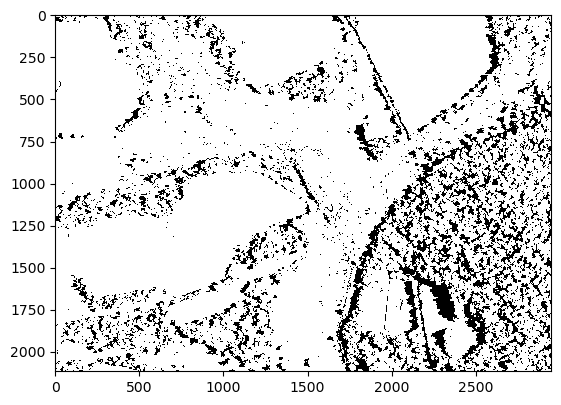

In [23]:
"""Load shadow mask"""
mask_file = '{}/results/shadow_mask.tif{}'.format(path, params)
mask_src = rasterio.open(mask_file)

# read mask data into a boolean array
shade = np.squeeze(mask_src.read()).astype(bool)

fig, ax = plt.subplots(1, 1)
ax.imshow(shade, cmap='gray_r', interpolation='none')

plt.show()

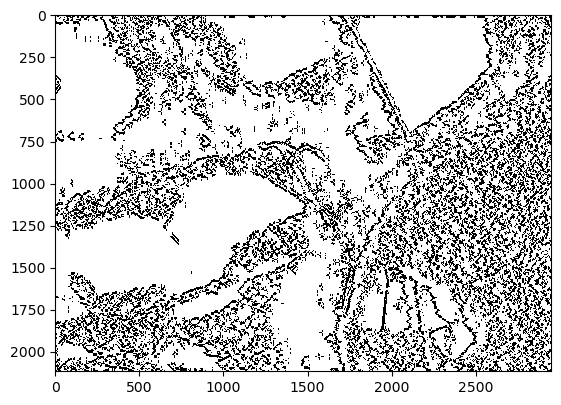

In [24]:
# THIS ACTUALLY WORKS BEST SAMPLING ~shade PIXELS
# WITH SUNLIT_MASK THE FORESTED AREAS OVERWHELM THE RANDOM SAMPLE
# COULD THE SUNLIT_MASK WORK BETTER IF USING THE XY POSITION OF THE SAMPLES?

"""Load sunlit mask"""
sunmask_file = '{}/results/sunlit_mask.tif{}'.format(path, params)
sunmask_src = rasterio.open(sunmask_file)

# read mask data into a boolean array
sunlit = np.squeeze(sunmask_src.read()).astype(bool)

fig, ax = plt.subplots(1, 1)
ax.imshow(sunlit, cmap='gray_r', interpolation='none')

plt.show()


## Make the input data

In [25]:
"""Create a band-first image in new working colorspace"""
# band_cs = rgb2lab(rgb[:3,:,:], channel_axis=0)
# channels = ['L*', 'a*', 'b*']

_band_cs = rgb2hsv(rgb[:3,:,:], channel_axis=0)
band_cs = np.append(_band_cs, rgb[[3],:,:]/255, axis=0)
channels = ['H', 'S', 'V', 'NIR']

What do the HSV image histograms look like inside and outside the shadow mask? 

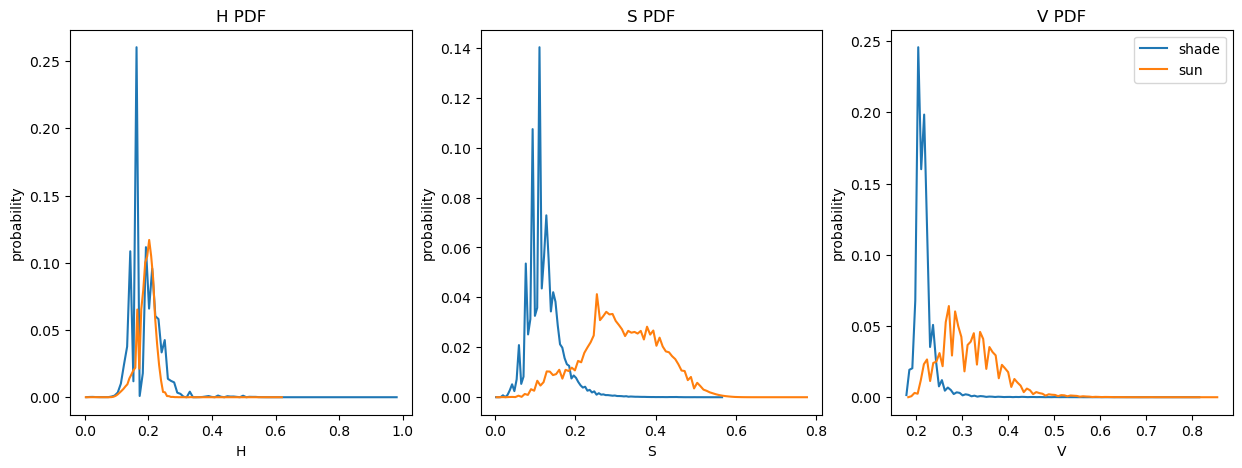

In [26]:
from scipy import stats

nbins = 100

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15, 5))

# shade nbins is smaller because few pixels and many bins yields unrealistic zero bins 
L_light_hist, L_light_centers = histogram(band_cs[0][~shade], nbins=nbins)
L_shade_hist, L_shade_centers = histogram(band_cs[0][shade], nbins=nbins)

ax0.plot(L_shade_centers, L_shade_hist/np.sum(L_shade_hist), label='shade')
ax0.plot(L_light_centers, L_light_hist/np.sum(L_light_hist), label='sun')
ax0.set_title(f"{channels[0]} PDF")
ax0.set_xlabel(f'{channels[0]}')
ax0.set_ylabel('probability')

a_light_hist, a_light_centers = histogram(band_cs[1][~shade], nbins=nbins)
a_shade_hist, a_shade_centers = histogram(band_cs[1][shade], nbins=nbins)

ax1.plot(a_shade_centers, a_shade_hist/np.sum(a_shade_hist), label='shade')
ax1.plot(a_light_centers, a_light_hist/np.sum(a_light_hist), label='sun')
ax1.set_title(f"{channels[1]} PDF")
ax1.set_xlabel(f'{channels[1]}')
ax1.set_ylabel('probability')

b_light_hist, b_light_centers = histogram(band_cs[2][~shade], nbins=nbins)
b_shade_hist, b_shade_centers = histogram(band_cs[2][shade], nbins=nbins)

ax2.plot(b_shade_centers, b_shade_hist/np.sum(b_shade_hist), label='shade')
ax2.plot(b_light_centers, b_light_hist/np.sum(b_light_hist), label='sun')
ax2.set_title(f"{channels[2]} PDF")
ax2.set_xlabel(f'{channels[2]}')
ax2.set_ylabel('probability')

plt.legend()
plt.show()

## Shadow removal with optimal transport

Can we eliminate the shadows using optimal transport? This follows the example from the POT documentation:
[OT for image color adaptation with mapping estimation](https://pythonot.github.io/auto_examples/domain-adaptation/plot_otda_mapping_colors_images.html#sphx-glr-auto-examples-domain-adaptation-plot-otda-mapping-colors-images-py)

In [27]:
def im2mat(img):
    """Converts an image to matrix (one pixel per line)"""
    # return img.reshape(img.shape[1] * img.shape[2], img.shape[0]) 
    return img.reshape(img.shape[0] * img.shape[1], img.shape[2])


def mat2im(X, shape):
    """Converts back a matrix to an image"""
    return X.reshape(shape)


def minmax(img):
    return np.clip(img, 0, 1)

In [28]:
rng = np.random.RandomState(42)

shade_flat_mask = shade.flatten()
sunlit_flat_mask = sunlit.flatten()

img_cs = np.moveaxis(band_cs, 0, 2)

# Transform the image data to matrices
X = im2mat(img_cs)

# do the values agree?
print(f'Matrix {channels[0]}{channels[1]}{channels[2]} value ranges')
print(img_cs[:,:,0].min(), img_cs[:,:,0].max())
assert (img_cs[:,:,0].min() == X[:,0].min()) & (img_cs[:,:,0].max() == X[:,0].max())
print(img_cs[:,:,1].min(), img_cs[:,:,1].max())
assert (img_cs[:,:,1].min() == X[:,1].min()) & (img_cs[:,:,1].max() == X[:,1].max())
print(img_cs[:,:,2].min(), img_cs[:,:,2].max())
assert (img_cs[:,:,2].min() == X[:,2].min()) & (img_cs[:,:,2].max() == X[:,2].max())

X1 = X[shade_flat_mask, :]   # the shade
X2 = X[sunlit_flat_mask, :]  # the sun
print("shade pixels", X1.shape)
print("sun pixels", X2.shape)

# training samples
nb = 4000
idx1 = rng.randint(X1.shape[0], size=(nb,))
idx2 = rng.randint(X2.shape[0], size=(nb,))

# Xs is the source, Xt is the target; we want to transport the shaded areas to the sunlit areas
Xs = X1[idx1, :] # the shade sample
Xt = X2[idx2, :] # the sun sample

Matrix HSV value ranges
0.0 0.9861111111111112
0.0 0.7810650887573963
0.1764705882352941 0.8588235294117647
shade pixels (858818, 4)
sun pixels (1372784, 4)


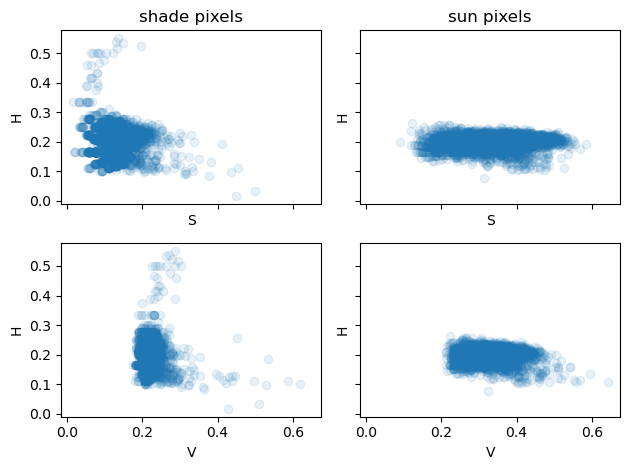

In [29]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)

# not going to color the samples here
# plt.scatter(Xs[:, 1], Xs[:, 2], c=Xs)
ax0.scatter(Xs[:, 1], Xs[:, 0], alpha=0.1)
ax0.set_xlabel(f'{channels[1]}')
ax0.set_ylabel(f'{channels[0]}')
ax0.set_title('shade pixels')

# not going to color the samples here
# plt.scatter(Xt[:, 1], Xt[:, 2], c=Xt)
ax1.scatter(Xt[:, 1], Xt[:, 0], alpha=0.1)
ax1.set_xlabel(f'{channels[1]}')
ax1.set_ylabel(f'{channels[0]}')
ax1.set_title('sun pixels')

ax2.scatter(Xs[:, 2], Xs[:, 0], alpha=0.1)
ax2.set_xlabel(f'{channels[2]}')
ax2.set_ylabel(f'{channels[0]}')
# ax2.set_title('shade sample pixels')

ax3.scatter(Xt[:, 2], Xt[:, 0], alpha=0.1)
ax3.set_xlabel(f'{channels[2]}')
ax3.set_ylabel(f'{channels[0]}')
# ax3.set_title('sun sample pixels')

plt.tight_layout()

In [30]:
# Shadows tend toward blue as opposed to the sunlit parts...
# 1/3 or 120 degrees is green, 
# 1/2 or 180 degrees is cyan
# 2/3 or 270 degrees is blue
# so do we need to transport the hue as well?

In [33]:
'''
Each OT model has three basic steps:
- initialize an optimal transport model
- fit a source data, Xs, to a target data, Xt
- transform a source data
'''
import ot

fit_dims = 0 # Use 1 if HSV to use the SV channels, 0 if Lab to use the Lab channels

start_time = timeit.default_timer()

'''
# LINEAR MAPPING TRANSPORT (reasonable results, but X1_transformed * 0.9 provides better match)
ot_mapping_linear = ot.da.MappingTransport(
    mu=1e0, eta=1e-8, bias=True, max_iter=20, verbose=True)
ot_mapping_linear.fit(Xs=Xs, Xt=Xt[:,fit_dims:])                        # fit Xs (shade sample) to Xt (sun sample)
X1_transformed_dims = ot_mapping_linear.transform(Xs=X1[:,fit_dims:])   # transform the full image matrix

'''
# EMD TRANSPORT (reasonable results)
ot_emd = ot.da.EMDTransport(max_iter=200000)
ot_emd.fit(Xs=Xs[:,fit_dims:], Xt=Xt[:,fit_dims:])
X1_transformed_dims = ot_emd.transform(Xs=X1[:,fit_dims:])


'''
# SINKHORN TRANSPORT (produces too uniform a result)
ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-1)
ot_sinkhorn.fit(Xs=Xs[:,fit_dims:], Xt=Xt[:,fit_dims:])
X1_transformed_dims = ot_sinkhorn.transform(Xs=X1[:,fit_dims:])
'''

# update the X matrix with X1_transformed inserted at flat_mask coordinates
#X1_transformed = X1.copy()
#X1_transformed[:,fit_dims:] = X1_transformed_dims
X1_transformed = X1_transformed_dims

elapsed = timeit.default_timer() - start_time
print(f'Elapsed time: {elapsed}')
print('')
print(f'Source-Transformed {channels[0]}{channels[1]}{channels[2]} value ranges:')
print(X1_transformed[:, 0].min(), X1_transformed[:, 0].max())
print(X1_transformed[:, 1].min(), X1_transformed[:, 1].max())
print(X1_transformed[:, 2].min(), X1_transformed[:, 2].max())


Elapsed time: 746.4785316999769

Source-Transformed HSV value ranges:
-0.0009920634920635857 0.6861111111111113
0.08023715415019769 0.7944135400639128
0.16470588235294117 0.792156862745098


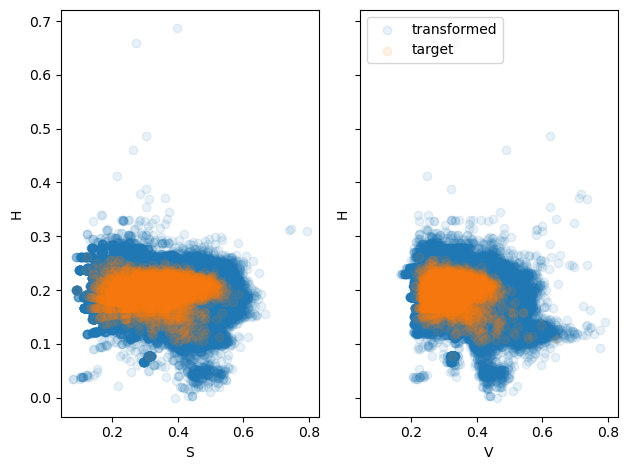

In [34]:
# compare the transformed data to the target sample
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

ax0.scatter(X1_transformed[:, 1], X1_transformed[:, 0], alpha=0.1, label='transformed')
ax0.scatter(Xt[:, 1], Xt[:, 0], alpha=0.1, label='target')
ax0.set_xlabel(f'{channels[1]}')
ax0.set_ylabel(f'{channels[0]}')

ax1.scatter(X1_transformed[:, 2], X1_transformed[:, 0], alpha=0.1, label='transformed')
ax1.scatter(Xt[:, 2], Xt[:, 0], alpha=0.1, label='target')
ax1.set_xlabel(f'{channels[2]}')
ax1.set_ylabel(f'{channels[0]}')

plt.legend(loc='upper left')
plt.tight_layout()

In [35]:
# the row indices to replace
ix = np.argwhere(shade_flat_mask).flatten()

# update the X matrix with X1_transformed inserted at flat_mask coordinates
X[ix, :] = X1_transformed

# reshape the updated L*a*b* matrix, X, back to an image
img_transformed = mat2im(X[:,:3], img[:,:,:3].shape)
img_transformed = mat2im(X, img.shape)

img_transformed = np.clip(img_transformed, 0, 1)

# print the value ranges...does it look reasonable???
print(f'Image Including Transformed {channels[0]}{channels[1]}{channels[2]} value ranges')
print(img_transformed[:, :, 0].min(), img_transformed[:, :, 0].max())
print(img_transformed[:, :, 1].min(), img_transformed[:, :, 1].max())
print(img_transformed[:, :, 2].min(), img_transformed[:, :, 2].max())

# double-check!
assert (img_transformed[:, :, 0].min() >= 0) & (img_transformed[:, :, 0].max() <= 1)
assert (img_transformed[:, :, 1].min() >= 0) & (img_transformed[:, :, 1].max() <= 1)
assert (img_transformed[:, :, 2].min() >=0) & (img_transformed[:, :, 2].max() <= 1)

# if L*a*b*
#assert (img_transformed[:, :, 0].min() >= 0) & (img_transformed[:, :, 0].max() <= 100)
#assert (img_transformed[:, :, 1].min() >= -128) & (img_transformed[:, :, 1].max() <= 127)
#assert (img_transformed[:, :, 2].min() >=-128) & (img_transformed[:, :, 2].max() <= 127)

Image Including Transformed HSV value ranges
0.0 0.6861111111111113
0.0 0.7944135400639128
0.16470588235294117 0.8588235294117647


In [36]:
# convert the lab image to rgb
rgb_transformed_flt = hsv2rgb(img_transformed[:,:,:3])

In [37]:
rgb_transformed = (np.rint(rgb_transformed_flt*255)).astype(np.uint8)
rgb_transformed_bands = np.moveaxis(rgb_transformed, 2, 0)

# put the transformed nir band back
# nir_transformed = (np.rint(img_transformed[:,:,[3]]*255)).astype(np.uint8)
# rgb_transformed_bands = np.append(band_cs_, rgb[[3],:,:], axis=0)

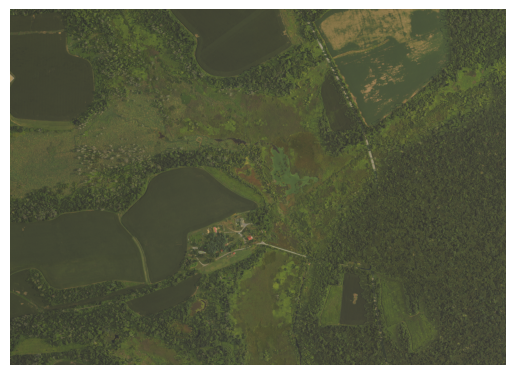

In [38]:
fig, ax0 = plt.subplots(nrows=1, ncols=1)
ax0.imshow(rgb_transformed)
ax0.axis('off')
plt.show()

## Write out the results

Running this cell will write out two files to the results directory.

In [39]:
out_raster = './results/shadow_corrected.tif'

""" Write out the classification result in raster format """
with rasterio.open(
    out_raster,
    'w',
    driver='GTiff',
    height=rgb_transformed_bands.shape[1],
    width=rgb_transformed_bands.shape[2],
    count=rgb_transformed_bands.shape[0],
    dtype=rgb_transformed_bands.dtype,
    crs=src.crs,
    transform=src.transform,
) as dst:
    dst.write(rgb_transformed_bands)
    
src.close()


# How does this compare with equalizing histograms?

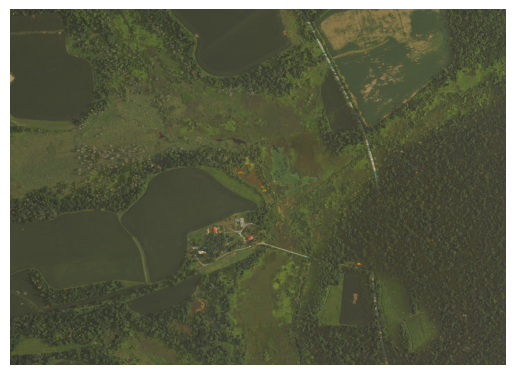

In [42]:
# compare with multiplying H and V

from skimage.exposure import rescale_intensity

X1_transformed = np.stack((
    (X1[:,0]-0.1)*0.8+0.1,
    X1[:,1]*2.2+0.05,
    X1[:,2]+(X1[:,2]-X1[:,2].min())*1.8,
    X1[:,3]),
    axis = 1)

'''
X1_transformed = np.stack((
    rescale_intensity(X1[:,0], in_range=(Xt[:,0].min(), Xt[:,0].max())),
    rescale_intensity(X1[:,1], in_range=(Xt[:,1].min(), Xt[:,1].max())),
    rescale_intensity(X1[:,2], in_range=(Xt[:,2].min(), Xt[:,2].max())),
    X1[:,3]),
    axis = 1)
'''

# update the X matrix with X1_transformed inserted at flat_mask coordinates
X[ix, :] = X1_transformed

# reshape the updated L*a*b* matrix, X, back to an image
img_transformed = mat2im(X[:,:3], img[:,:,:3].shape)
img_transformed = mat2im(X, img.shape)

img_transformed = np.clip(img_transformed, 0, 1)

# convert the lab image to rgb
rgb_transformed_flt = hsv2rgb(img_transformed[:,:,:3])

rgb_transformed = (np.rint(rgb_transformed_flt*255)).astype(np.uint8)
rgb_transformed_bands = np.moveaxis(rgb_transformed, 2, 0)

fig, ax0 = plt.subplots(nrows=1, ncols=1)
ax0.imshow(rgb_transformed)
ax0.axis('off')
plt.show()

In [43]:
out_raster = './results/shadow_scaled.tif'

""" Write out the classification result in raster format """
with rasterio.open(
    out_raster,
    'w',
    driver='GTiff',
    height=rgb_transformed_bands.shape[1],
    width=rgb_transformed_bands.shape[2],
    count=rgb_transformed_bands.shape[0],
    dtype=rgb_transformed_bands.dtype,
    crs=src.crs,
    transform=src.transform,
) as dst:
    dst.write(rgb_transformed_bands)
